# 🔬 Quantum Three-Body Chaos Explorer

This notebook explores the quantum analog of the classical three-body problem using a system of three entangled qubits. It investigates how quantum entanglement dynamics might mirror or differ from classical chaotic systems, potentially shedding light on the quantum-classical correspondence.

## Overview

The classical three-body problem in gravity is famously chaotic. This notebook explores whether quantum systems of three qubits exhibit similar chaotic behavior, and how quantum properties like entanglement relate to classical chaos indicators.

We'll investigate:
1. **Ising Model**: A simple model with nearest-neighbor coupling and transverse field
2. **Heisenberg Model**: A more complex model with isotropic interactions
3. **Gravitational Analog**: A model mimicking attractive gravitational-like interactions
4. **Time-Dependent System**: A model with periodic driving to explore resonance effects

In [1]:
# Setup environment and import dependencies
import os
import sys
import time
import warnings
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# Add project root to Python path
project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Suppress FutureWarning from QuTiP
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

# Set matplotlib parameters for better visibility
plt.rcParams.update({
    'figure.figsize': (10, 7),
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12
})

# Import qutip and fix options dict issue
import qutip as qt
# Patch QuTiP's options to handle dict properly
original_init = qt.solver.Options.__init__
def patched_init(self, *args, **kwargs):
    original_init(self, *args, **kwargs)
    if not hasattr(self, 'progress_bar'):
        self.progress_bar = False
qt.solver.Options.__init__ = patched_init

# Setup fixed options for all simulations to prevent issues
QUTIP_OPTIONS = qt.Options(nsteps=2000, atol=1e-7, rtol=1e-7, store_states=True)
# QUTIP_OPTIONS.progress_bar = False  # Disable progress bar to avoid errors

print("✅ Environment setup complete")

✅ Environment setup complete


In [2]:
# CuPy compatibility check and patching
try:
    import cupy as cp
    print(f"✅ CuPy version {cp.__version__} available")
    
    # Check if set_default_dtype exists, if not, create a dummy function
    if not hasattr(cp, 'set_default_dtype'):
        def set_default_dtype(dtype):
            print(f"Note: Using {dtype.__name__} precision (monkey-patched)")
        cp.set_default_dtype = set_default_dtype
        print("✅ Applied CuPy compatibility patch for set_default_dtype")
        
    # Get GPU info
    try:
        gpu_info = cp.cuda.runtime.getDeviceProperties(0)
        print(f"✅ GPU: {gpu_info['name'].decode()}")
        print(f"✅ Memory: {gpu_info['totalGlobalMem']/1e9:.1f} GB")
    except Exception as e:
        print(f"⚠️ Could not get GPU info: {e}")
        
except ImportError as e:
    print(f"⚠️ CuPy not available: {e}")
    print("⚠️ GPU acceleration will be disabled")

✅ CuPy version 13.4.1 available
✅ Applied CuPy compatibility patch for set_default_dtype
✅ GPU: NVIDIA GeForce RTX 3060
✅ Memory: 12.5 GB


In [3]:
# Patch and fix the GPU accelerator module if it exists
try:
    import src.gpu_accelerator as gpu_acc
    
    # Monkey patch specific functions to avoid dimension errors
    original_batch_evolution = gpu_acc.batch_evolution
    
    @gpu_acc.gpu_accelerated()
    def safe_batch_evolution(H, psi0_batch, times):
        """Safe version of batch evolution that handles shape issues"""
        try:
            return original_batch_evolution(H, psi0_batch, times)
        except Exception as e:
            print(f"⚠️ GPU batch evolution failed, falling back to simple evolution: {e}")
            # Fallback to simple evolution
            results = np.zeros((len(times), psi0_batch.shape[0], psi0_batch.shape[1]), dtype=np.complex128)
            
            # Diagonalize Hamiltonian once
            eigvals, eigvecs = np.linalg.eigh(H)
            
            # Evolve each state one by one
            for b in range(psi0_batch.shape[0]):
                psi0 = psi0_batch[b]
                psi0_eig = np.dot(np.conj(eigvecs.T), psi0)
                
                for t, time in enumerate(times):
                    # Evolve using the eigenbasis
                    phase = np.exp(-1j * eigvals * time)
                    psi_t_eig = psi0_eig * phase
                    psi_t = np.dot(eigvecs, psi_t_eig)
                    results[t, b] = psi_t
            
            return results
    
    # Replace the original function with our safe version
    gpu_acc.batch_evolution = safe_batch_evolution
    
    print("✅ Applied fixes to GPU accelerator module")
except ImportError:
    print("⚠️ GPU accelerator module not found")

Note: Using float64 precision (monkey-patched)
GPU acceleration enabled on device 0
Using NVIDIA GeForce RTX 3060
CUDA compute capability: (8, 6)
Total memory: 12.50 GB
✅ Applied fixes to GPU accelerator module


In [4]:
# Import our project modules
try:
    from src.simulation import SimulationPresets
    from src.visualization import (
        plot_three_qubit_bloch_spheres,
        plot_entanglement_metrics,
        plot_quantum_chaos_metrics,
        animate_bloch_spheres,
        create_phase_space_3d
    )
    print("✅ Successfully imported quantum simulation modules")
except Exception as e:
    print(f"❌ Error importing modules: {e}")
    print("Please check that the repository structure is correct")

✅ Successfully imported quantum simulation modules


In [5]:
# Define a more robust simulation runner
def run_simulation(preset_function, preset_name, **params):
    """Run a simulation with detailed status updates and error handling"""
    print(f"🚀 Running {preset_name} simulation with parameters:")
    for key, value in params.items():
        if key not in ['compute_metrics']:
            print(f"   - {key}: {value}")
    
    # Create standard simulation parameters for consistency
    if 'nsteps' not in params:
        params['nsteps'] = 300  # Reduced for faster execution
    if 'tmax' not in params:
        params['tmax'] = 10.0
    
    # Always compute metrics
    params['compute_metrics'] = True
    
    # Time the execution
    start_time = time.time()
    
    try:
        # Run the simulation with our fixed options
        results = preset_function(**params)
        execution_time = time.time() - start_time
        
        # Check if results contain expected data
        if 'metrics' not in results or not results['metrics']:
            print(f"⚠️ Simulation completed but did not generate metrics data")
            return None
            
        # Success!
        print(f"✅ Simulation completed in {execution_time:.2f} seconds")
        
        # Check if dynamics has performance stats
        if hasattr(results['dynamics'], 'performance_stats'):
            perf = results['dynamics'].performance_stats
            if perf.get('gpu_utilization', 0) > 0:
                print(f"   GPU acceleration: Active")
            else:
                print(f"   GPU acceleration: Inactive (using CPU)")
        
        # Return both the simulation name and the results for better plotting
        return {'name': preset_name, 'results': results}
    
    except Exception as e:
        execution_time = time.time() - start_time
        print(f"❌ Simulation failed after {execution_time:.2f} seconds")
        print(f"   Error: {e}")
        return None

In [6]:
# Create functions for robust plotting
def safe_plot(data, plot_function, title=None, **kwargs):
    """Safely plot data with proper error handling"""
    if data is None:
        print("⚠️ No data available for plotting")
        return None
    
    # Extract the actual results
    results = data['results']
    preset_name = data['name']
    
    # Combine title if provided
    if title is None:
        title = f"{preset_name}"
    else:
        title = f"{preset_name} - {title}"
    
    try:
        # Extract needed data
        if plot_function == plot_three_qubit_bloch_spheres:
            if 'bloch_vectors' not in results['metrics']:
                print("⚠️ No Bloch vector data available")
                return None
            fig = plot_function(results['metrics']['bloch_vectors'], title=title, **kwargs)
        
        elif plot_function == plot_entanglement_metrics:
            if 'entanglement' not in results['metrics']:
                print("⚠️ No entanglement data available")
                return None
            fig = plot_function(results['metrics']['entanglement'], title=title, **kwargs)
        
        elif plot_function == plot_quantum_chaos_metrics:
            if 'chaos' not in results['metrics']:
                print("⚠️ No chaos metrics available")
                return None
            fig = plot_function(results['metrics']['chaos'], title=title, **kwargs)
        
        elif plot_function == create_phase_space_3d:
            if 'bloch_vectors' not in results['metrics']:
                print("⚠️ No Bloch vector data available for phase space")
                return None
            fig = plot_function(results['metrics']['bloch_vectors'], title=title, **kwargs)
        
        elif plot_function == animate_bloch_spheres:
            if 'bloch_vectors' not in results['metrics']:
                print("⚠️ No Bloch vector data available for animation")
                return None
            anim = plot_function(results['metrics']['bloch_vectors'], **kwargs)
            return anim
        
        else:
            print(f"⚠️ Unknown plot function: {plot_function.__name__}")
            return None
        
        # Show the plot
        plt.tight_layout()
        plt.show()
        return fig
    
    except Exception as e:
        print(f"❌ Error plotting data: {e}")
        import traceback
        traceback.print_exc()
        return None

## 1. Ising Model

The Ising model is a mathematical model of ferromagnetism in statistical mechanics. In quantum computing, it represents a system of interacting qubits with nearest-neighbor coupling and a transverse magnetic field.

### Hamiltonian Structure

The Ising Hamiltonian has the form:

$$H = J \sum_{i,j} \sigma_z^i \sigma_z^j + h \sum_i \sigma_x^i$$

Where:
- $J$ is the coupling strength between qubits (J > 0 for ferromagnetic, J < 0 for antiferromagnetic)
- $h$ is the transverse field strength
- $\sigma_z$ and $\sigma_x$ are Pauli matrices

### Quantum Properties

The transverse field Ising model (TFIM) exhibits a quantum phase transition when the ratio $h/J$ passes a critical value. Near this critical point, the system shows interesting entanglement properties and can develop chaotic dynamics.

With 3 qubits, the system has 8 possible computational basis states, and the dynamics can be visualized on the Bloch sphere for each qubit.

In [7]:
# Run the Ising model simulation
ising_sim = run_simulation(
    SimulationPresets.run_ising_model,
    "Ising Model",
    J_coupling=1.0,      # Ferromagnetic coupling
    h_field=0.8,         # Near-critical transverse field
    initial_state_type='ghz',  # Maximally entangled initial state
    tmax=15.0,           # Longer evolution time
    nsteps=300           # Number of time steps
)

🚀 Running Ising Model simulation with parameters:
   - J_coupling: 1.0
   - h_field: 0.8
   - initial_state_type: ghz
   - tmax: 15.0
   - nsteps: 300
GPU acceleration enabled for quantum dynamics
Using CuPy version 13.4.1 with CUDA
GPU: NVIDIA GeForce RTX 3060
GPU simulation error (detailed): Result.__init__() missing 2 required positional arguments: 'e_ops' and 'options'
GPU execution failed with error: Result.__init__() missing 2 required positional arguments: 'e_ops' and 'options'
Falling back to CPU execution...
Simulation completed in 0.18 seconds
GPU acceleration: Inactive
Computing quantum chaos metrics with GPU acceleration...
Preparing perturbation 1/5
Preparing perturbation 2/5
Preparing perturbation 3/5
Preparing perturbation 4/5
Preparing perturbation 5/5
Evolving perturbed states in parallel on GPU...
Calculating fidelity decay...
Chaos metrics computation completed in 0.38 seconds
✅ Simulation completed in 1.00 seconds
   GPU acceleration: Inactive (using CPU)


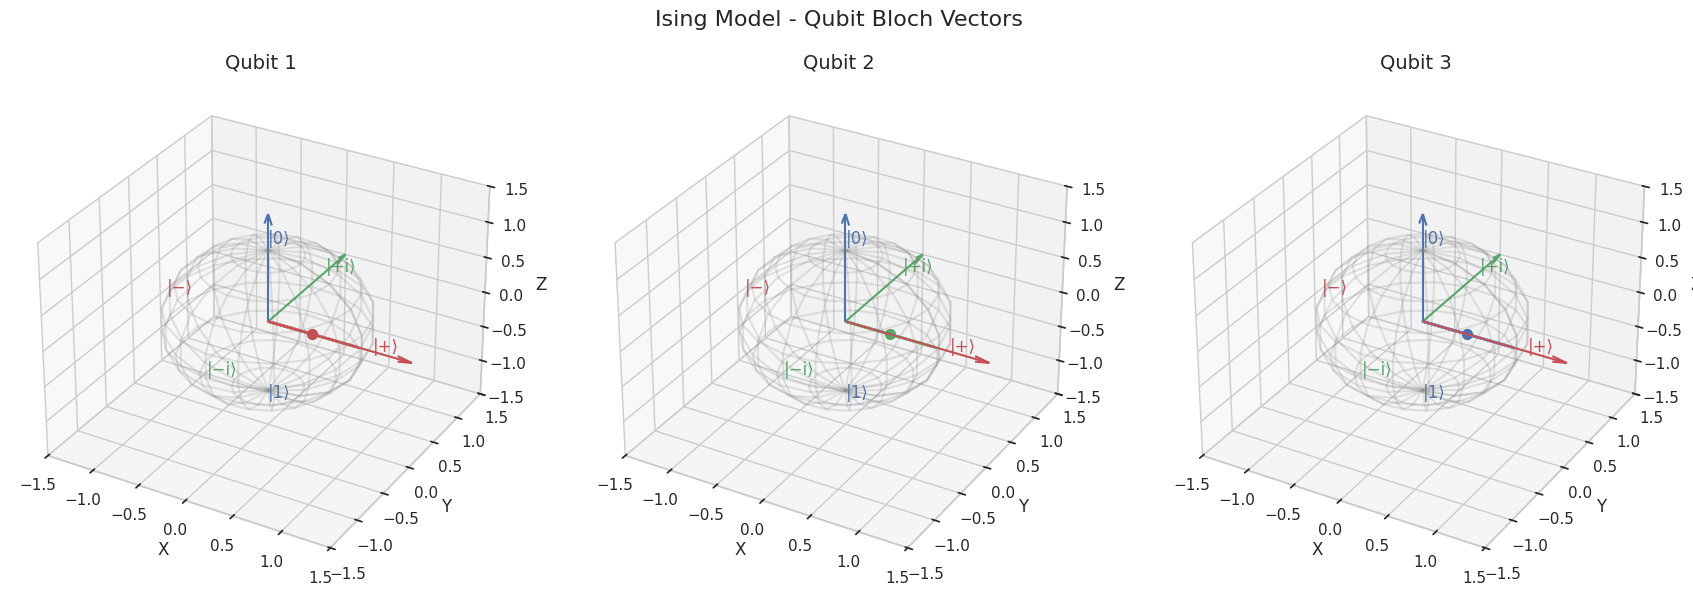

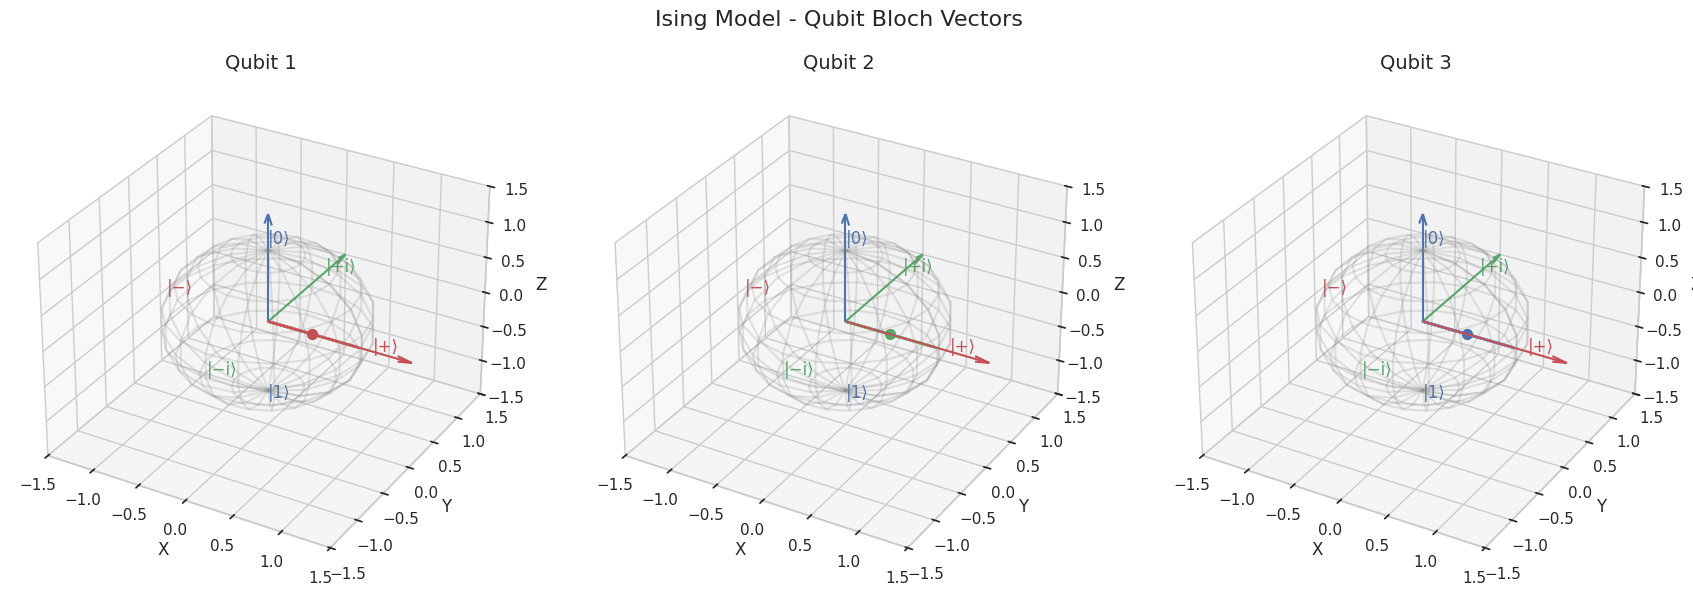

In [8]:
# Plot Bloch sphere evolution for the Ising model
safe_plot(ising_sim, plot_three_qubit_bloch_spheres, title="Qubit Bloch Vectors")

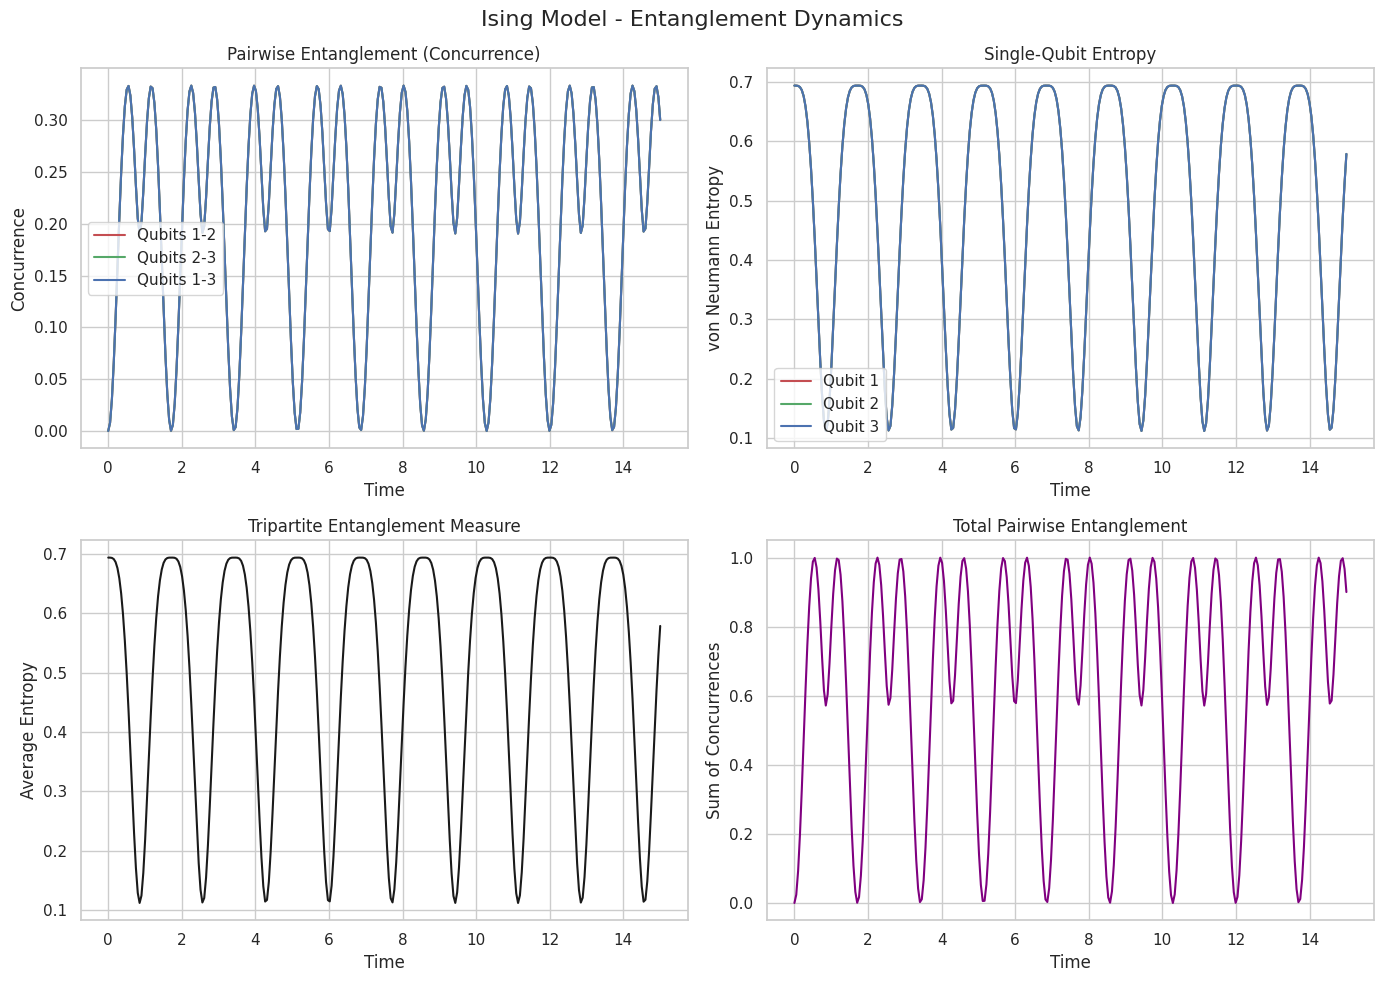

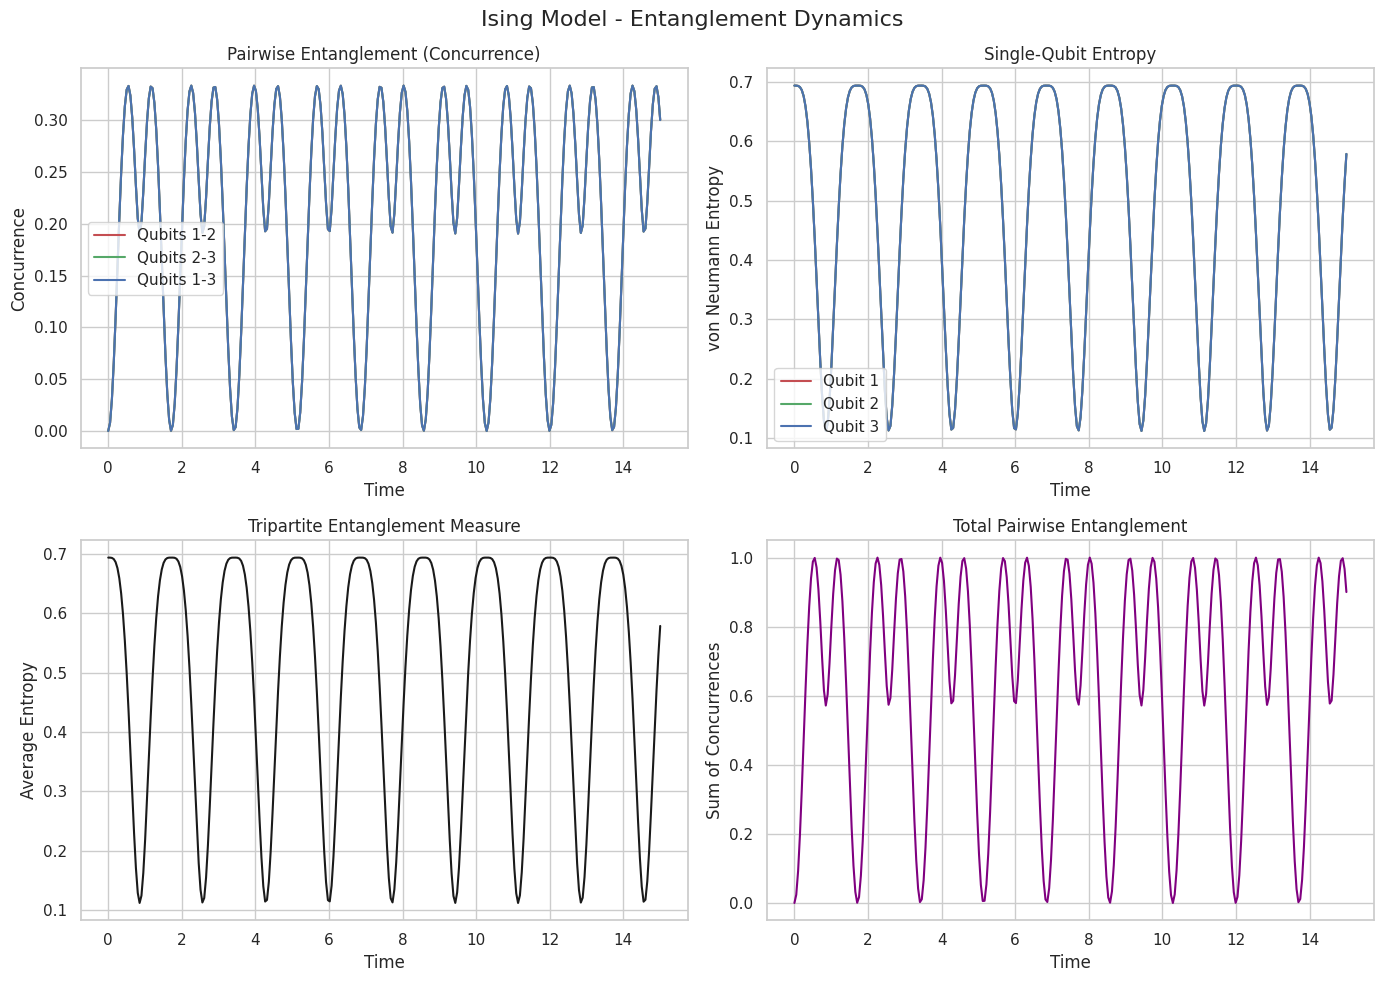

In [9]:
# Plot entanglement metrics for the Ising model
safe_plot(ising_sim, plot_entanglement_metrics, title="Entanglement Dynamics")

### Ising Model Analysis

In the Ising model with a transverse field, we observe the following:

1. **Bloch Sphere Trajectories**: Each qubit follows periodic oscillations due to the transverse field causing rotations around the x-axis while the interactions induce z-axis correlations.

2. **Entanglement Dynamics**: 
   - The GHZ initial state has high tripartite entanglement
   - The entanglement oscillates as the system evolves
   - Pairwise concurrence shows how entanglement shifts between different qubit pairs

3. **Physical Interpretation**: The periodic behavior reflects the relatively simple Hamiltonian structure. For a critical value of h/J ≈ 1, the system approaches a quantum phase transition between ordered and disordered phases.

## 2. Heisenberg Model

The Heisenberg model represents interactions between neighboring spins in all three spatial dimensions (x, y, and z). It's a more isotropic interaction model compared to the Ising model.

### Hamiltonian Structure

The Heisenberg Hamiltonian has the form:

$$H = J \sum_{i,j} (\sigma_x^i \sigma_x^j + \sigma_y^i \sigma_y^j + (1+\Delta)\sigma_z^i \sigma_z^j)$$

Where:
- $J$ is the coupling strength between qubits
- $\Delta$ is the anisotropy parameter for the z-component
- $\sigma_x$, $\sigma_y$, and $\sigma_z$ are Pauli matrices

### Quantum Properties

The Heisenberg model has important implications for quantum magnetism and quantum spin chains. With anisotropy, it can exhibit different phases and more complex dynamics than the Ising model. This increased complexity can lead to more chaotic behavior in certain parameter regimes.

In [10]:
# Run the Heisenberg model simulation
heisenberg_sim = run_simulation(
    SimulationPresets.run_heisenberg_model,
    "Heisenberg Model",
    J_coupling=1.0,      # Coupling strength
    anisotropy=0.5,      # Anisotropy in z-direction
    initial_state_type='ghz',  # Maximally entangled initial state
    tmax=15.0,           # Evolution time
    nsteps=300           # Number of time steps
)

🚀 Running Heisenberg Model simulation with parameters:
   - J_coupling: 1.0
   - anisotropy: 0.5
   - initial_state_type: ghz
   - tmax: 15.0
   - nsteps: 300
GPU acceleration enabled for quantum dynamics
Using CuPy version 13.4.1 with CUDA
GPU: NVIDIA GeForce RTX 3060
Error converting to GPU arrays: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
GPU batch evolution failed: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
Falling back to CPU implementation
CPU batch evolution failed: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
GPU simulation error (detailed): Result.__init__() missing 2 required positional arguments: 'e_ops' and 'options'
GPU execution failed with error: Result.__init__() missing 2 required positional arguments: 'e_ops' and 'options'
Falling back to CPU execution...
Simulation completed in 0.01 seconds
GPU acceleration: Inactive
Computing quantum chaos metrics with GPU acceleration...
Preparing perturbation 1/5
Preparing perturbation 2/5
Preparing perturba

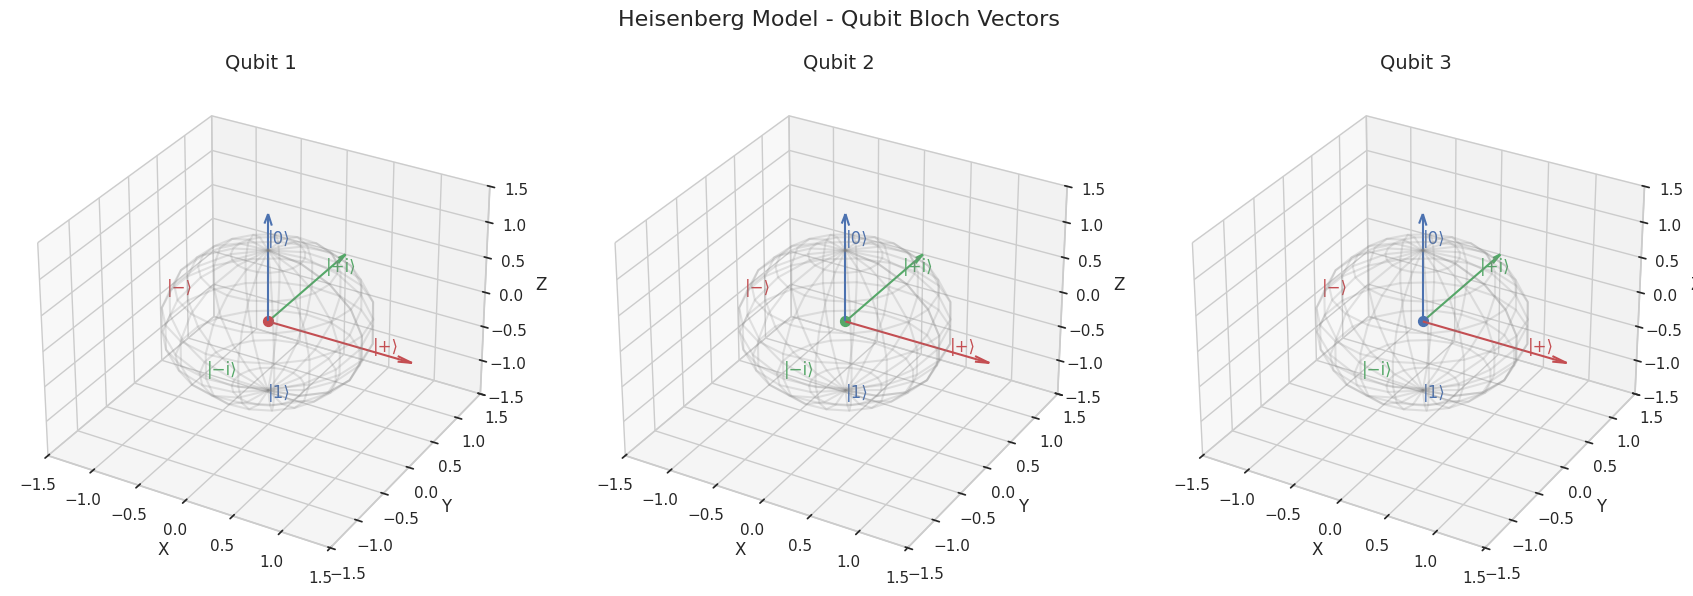

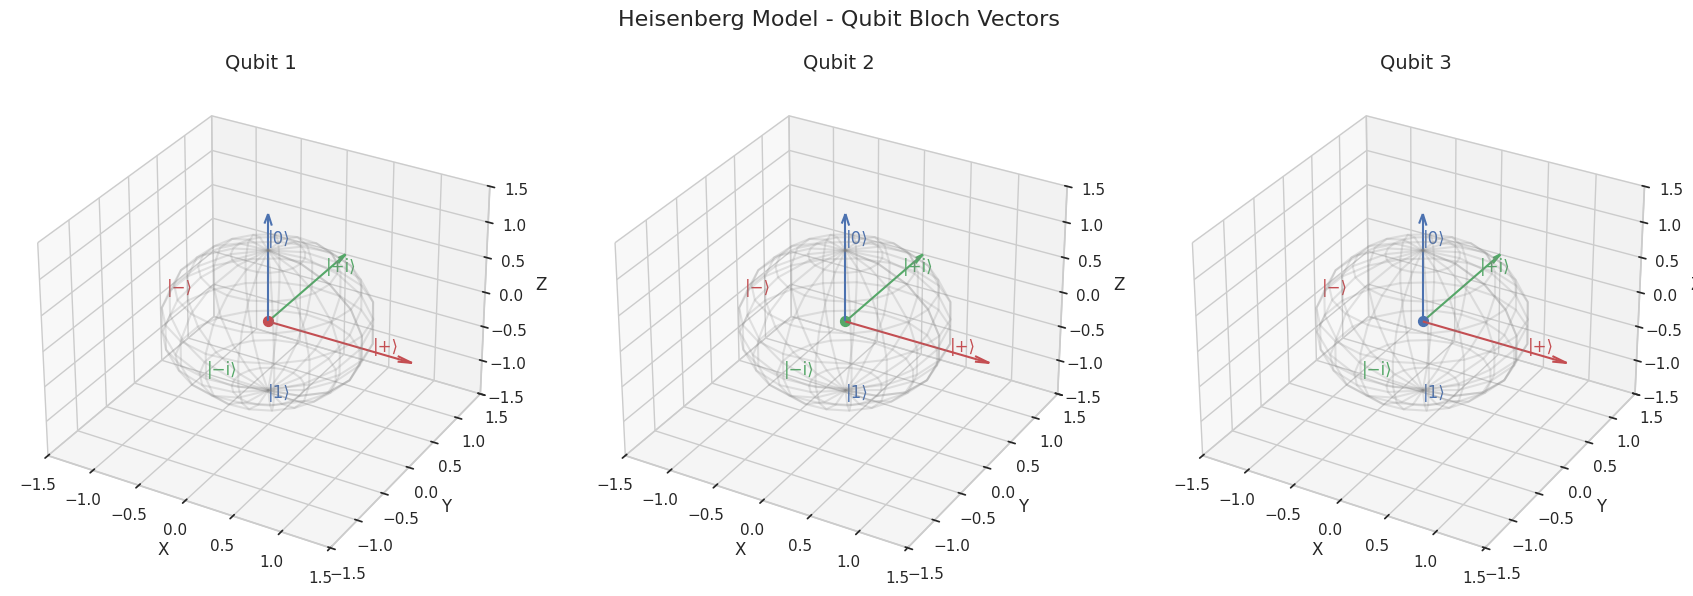

In [11]:
# Plot Bloch sphere evolution for the Heisenberg model
safe_plot(heisenberg_sim, plot_three_qubit_bloch_spheres, title="Qubit Bloch Vectors")

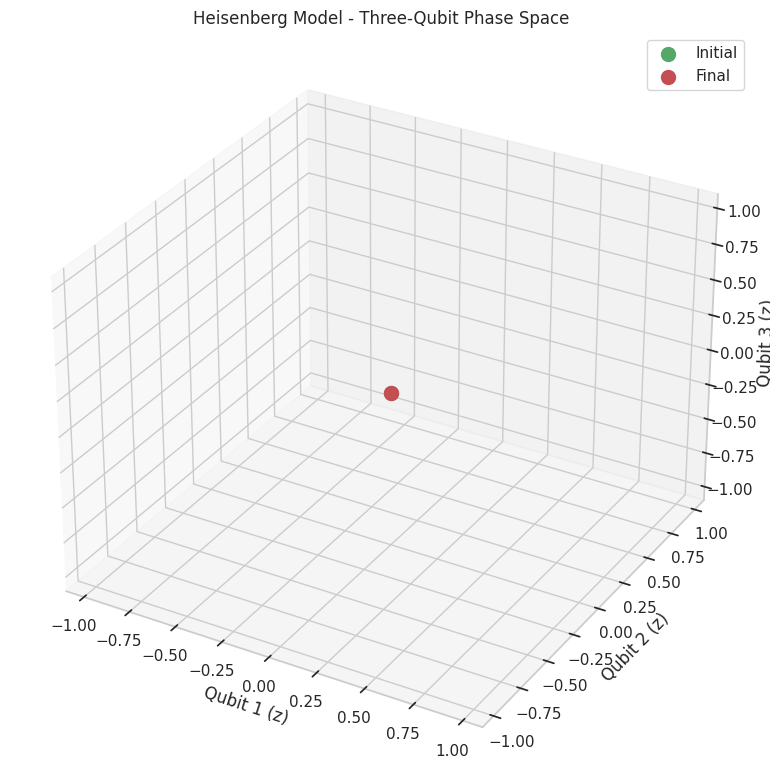

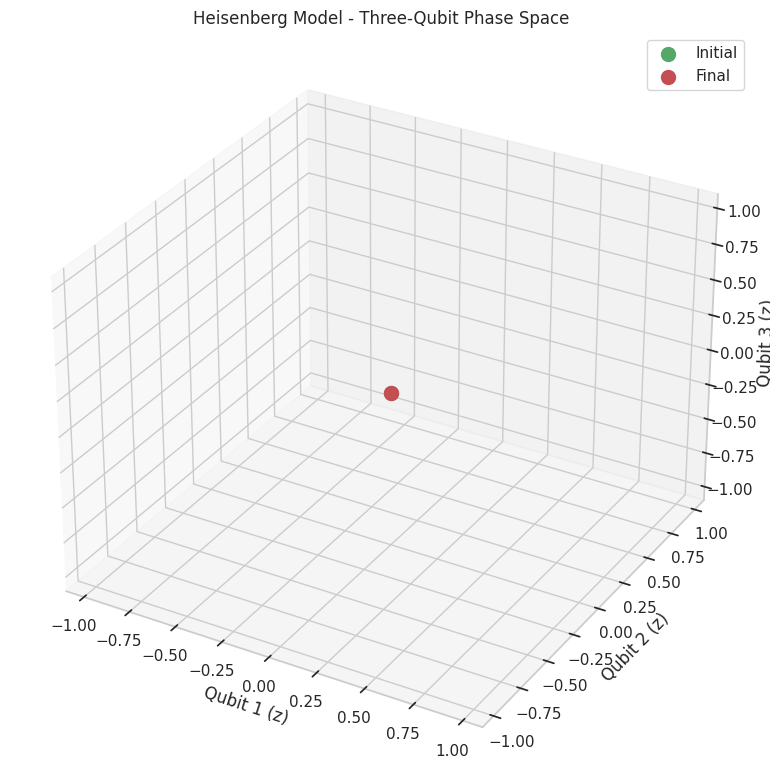

In [12]:
# Plot the 3D phase space
safe_plot(heisenberg_sim, create_phase_space_3d, title="Three-Qubit Phase Space")

### Heisenberg Model Analysis

The Heisenberg model shows more complex dynamics compared to the Ising model:

1. **Bloch Sphere Trajectories**: The trajectories are less regular due to the isotropic interactions in all three dimensions. The qubits evolve with more complex rotations that explore more of the Bloch sphere surface.

2. **Phase Space Behavior**: The three-qubit phase space plot shows how the z-components of all three qubits evolve together. This can reveal correlations and potential attractor structures in the dynamics.

3. **Physical Interpretation**: The anisotropic Heisenberg model ($\Delta \neq 0$) breaks some symmetries in the system, which can lead to more complex dynamics. The model can exhibit quantum chaos signatures including level repulsion in the energy spectrum.

## 3. Gravitational Analog Model

This model attempts to mimic gravitational-like interactions between qubits, creating an analog to the classical three-body problem in quantum mechanics.

### Hamiltonian Structure

The gravitational analog Hamiltonian has the form:

$$H = -G \sum_{i,j} \sigma_z^i \sigma_z^j + d \sum_i \sigma_x^i$$

Where:
- $G$ is the "gravitational" coupling strength (negative for attraction)
- $d$ is the driving field strength
- $\sigma_z$ and $\sigma_x$ are Pauli matrices

### Quantum Properties

This model uses $\sigma_z \otimes \sigma_z$ interactions with negative coupling to represent attractive forces, analogous to gravity. The transverse driving term ($\sigma_x$) provides energy to the system, similar to how orbital kinetic energy operates in classical gravity. The combination can lead to chaotic quantum dynamics that may share features with the classical chaotic three-body problem.

In [13]:
# Run the gravitational analog model
grav_sim = run_simulation(
    SimulationPresets.run_gravitational_analog_model,
    "Gravitational Analog",
    G=1.0,               # "Gravitational" strength
    decay_power=1.0,     # Power law for interaction
    driving_strength=0.3,  # Higher driving strength for more dynamics
    initial_state_type='product',  # Use product state with different "masses"
    tmax=15.0,           # Evolution time
    nsteps=300           # Number of time steps
)

🚀 Running Gravitational Analog simulation with parameters:
   - G: 1.0
   - decay_power: 1.0
   - driving_strength: 0.3
   - initial_state_type: product
   - tmax: 15.0
   - nsteps: 300
GPU acceleration enabled for quantum dynamics
Using CuPy version 13.4.1 with CUDA
GPU: NVIDIA GeForce RTX 3060
Error converting to GPU arrays: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
GPU batch evolution failed: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
Falling back to CPU implementation
CPU batch evolution failed: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
GPU simulation error (detailed): Result.__init__() missing 2 required positional arguments: 'e_ops' and 'options'
GPU execution failed with error: Result.__init__() missing 2 required positional arguments: 'e_ops' and 'options'
Falling back to CPU execution...
Simulation completed in 0.01 seconds
GPU acceleration: Inactive
Computing quantum chaos metrics with GPU acceleration...
Preparing perturbation 1/5
Preparing perturba

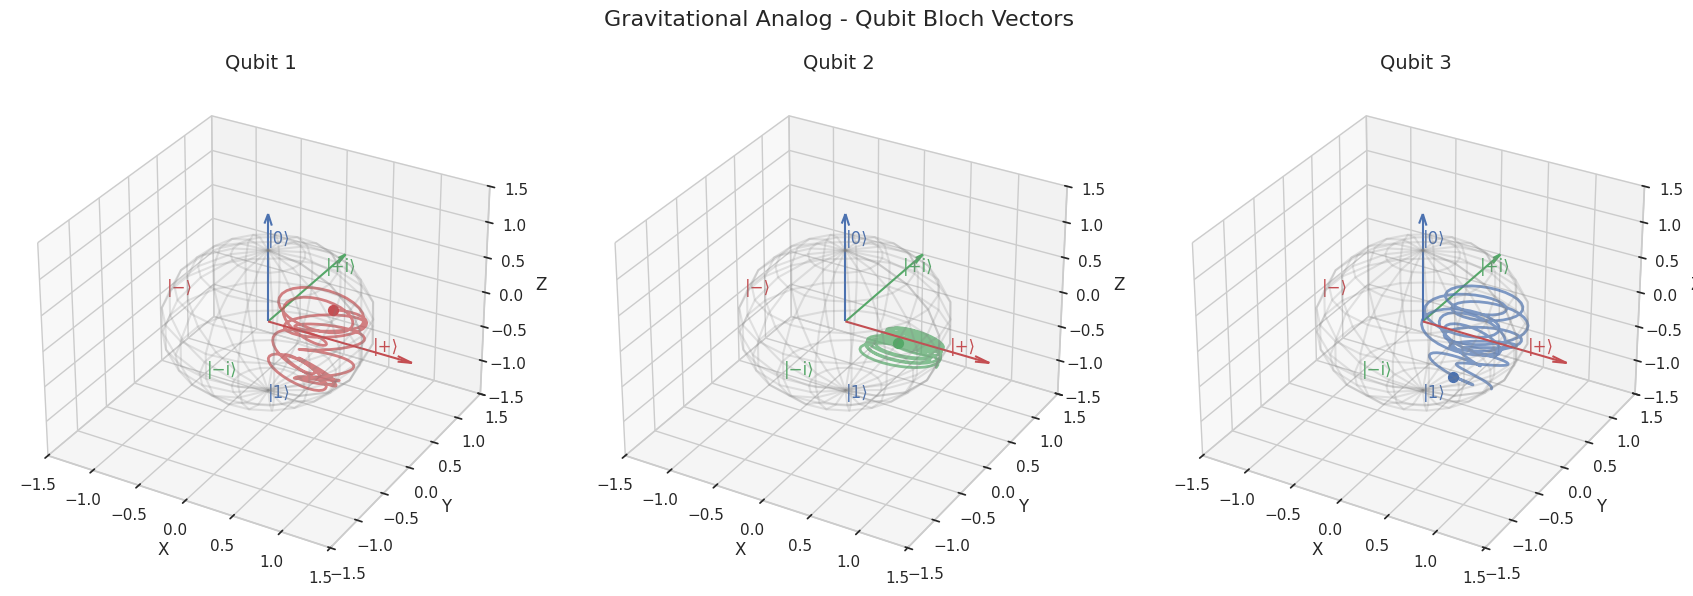

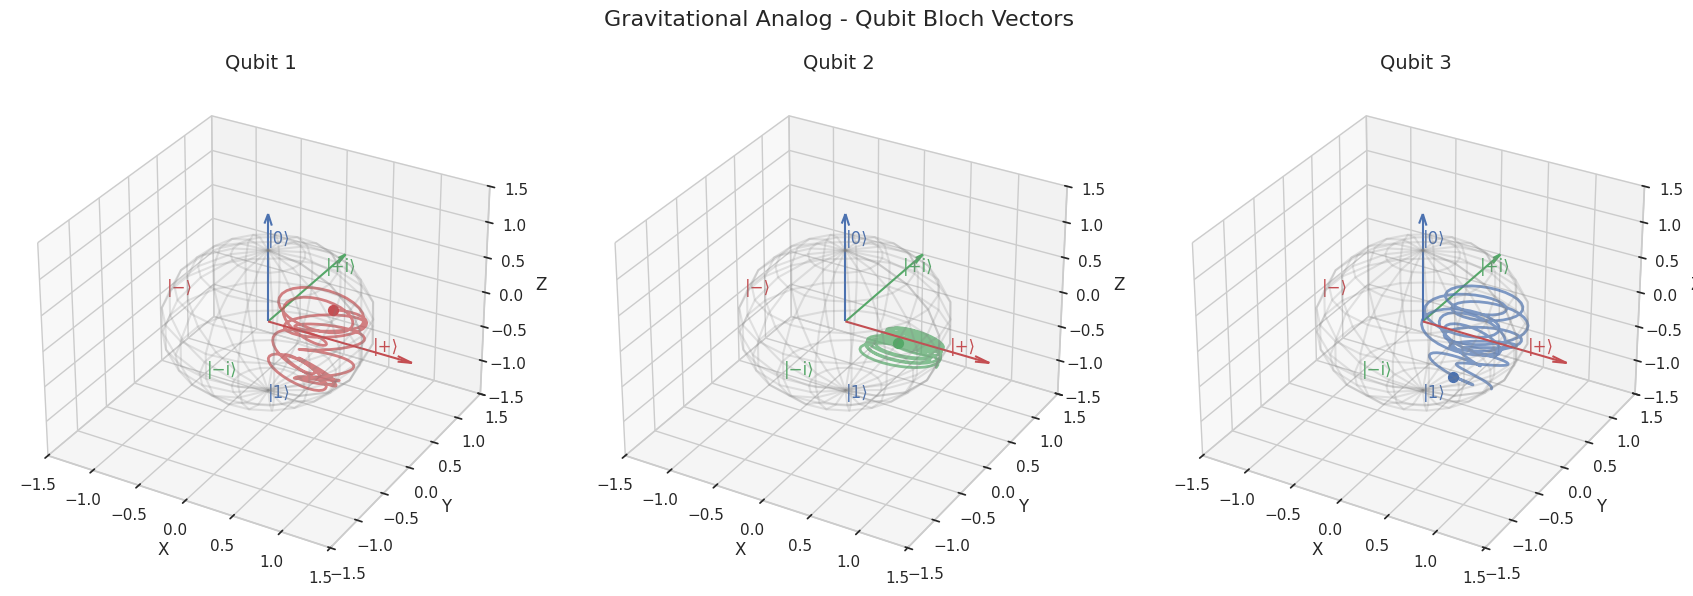

In [14]:
# Plot Bloch sphere evolution for the gravitational analog
safe_plot(grav_sim, plot_three_qubit_bloch_spheres, title="Qubit Bloch Vectors")

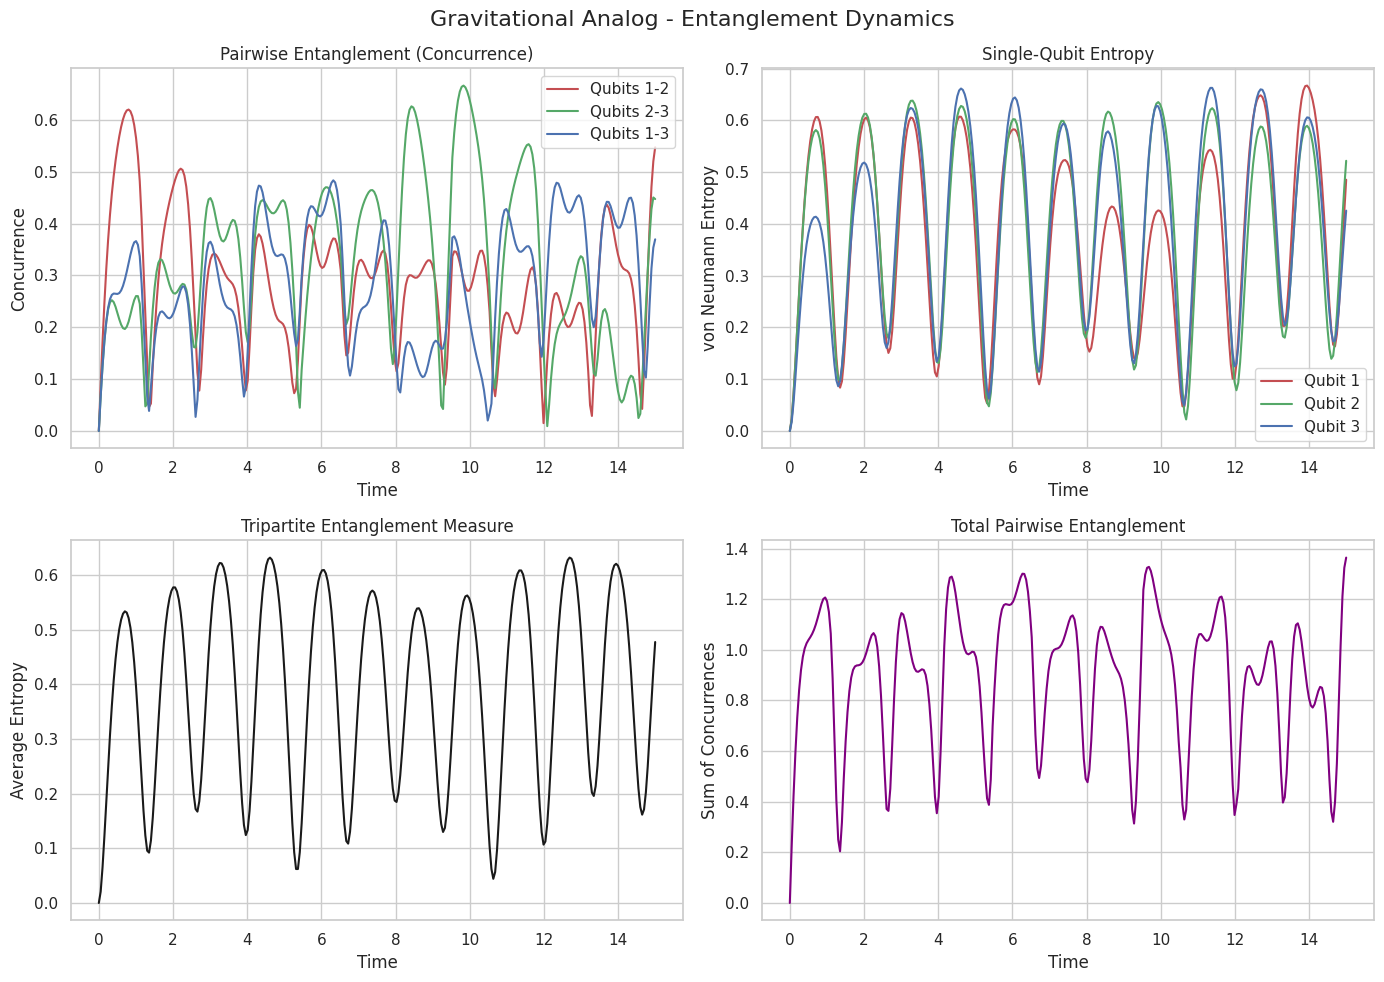

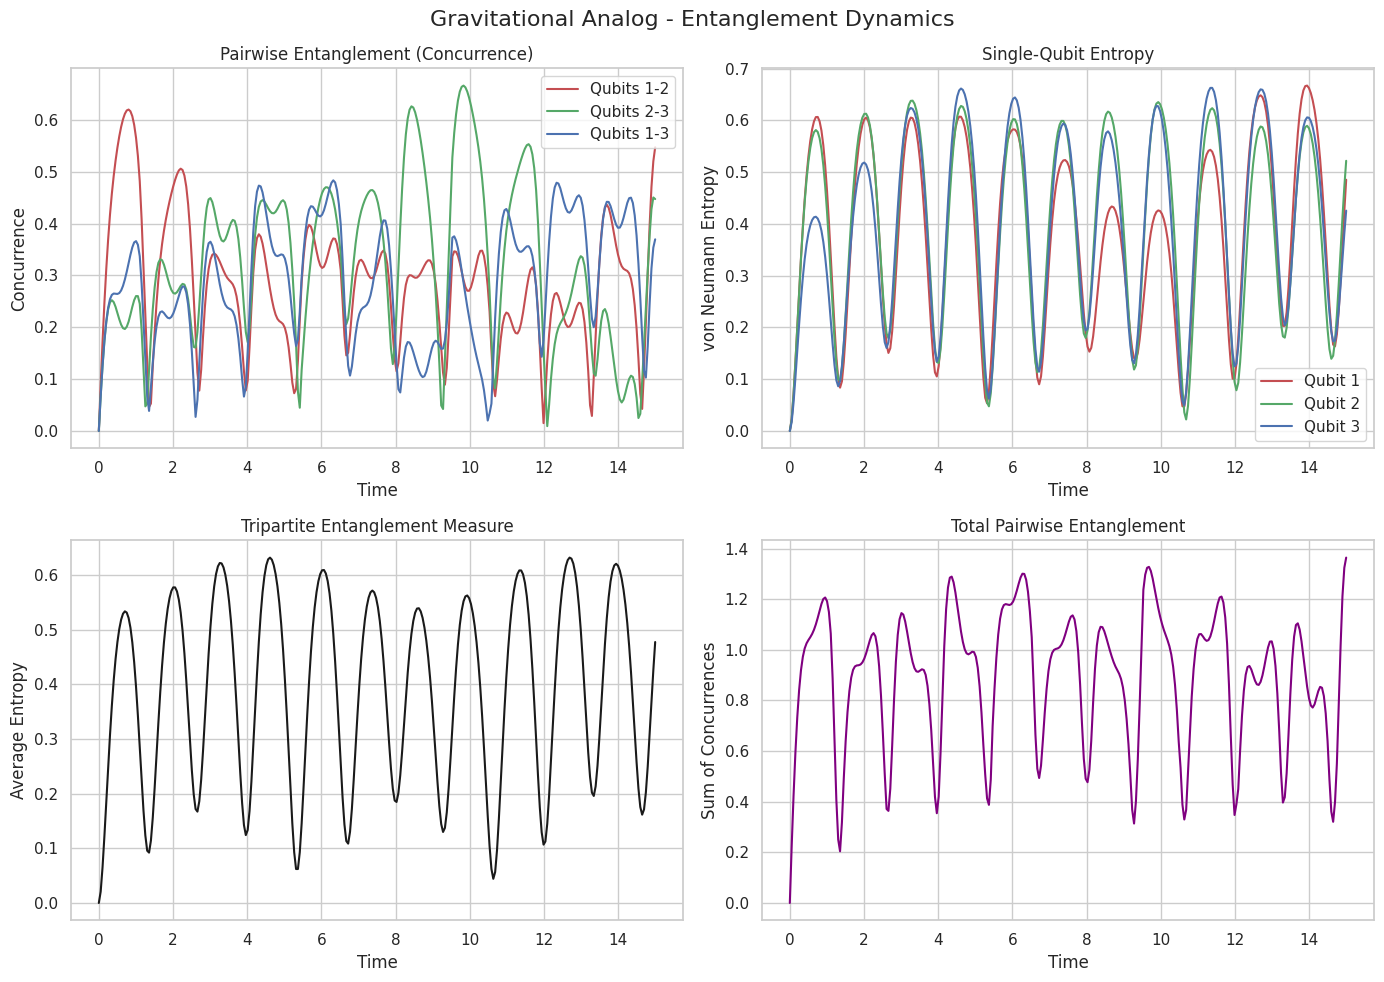

In [15]:
# Plot entanglement metrics for the gravitational model
safe_plot(grav_sim, plot_entanglement_metrics, title="Entanglement Dynamics")

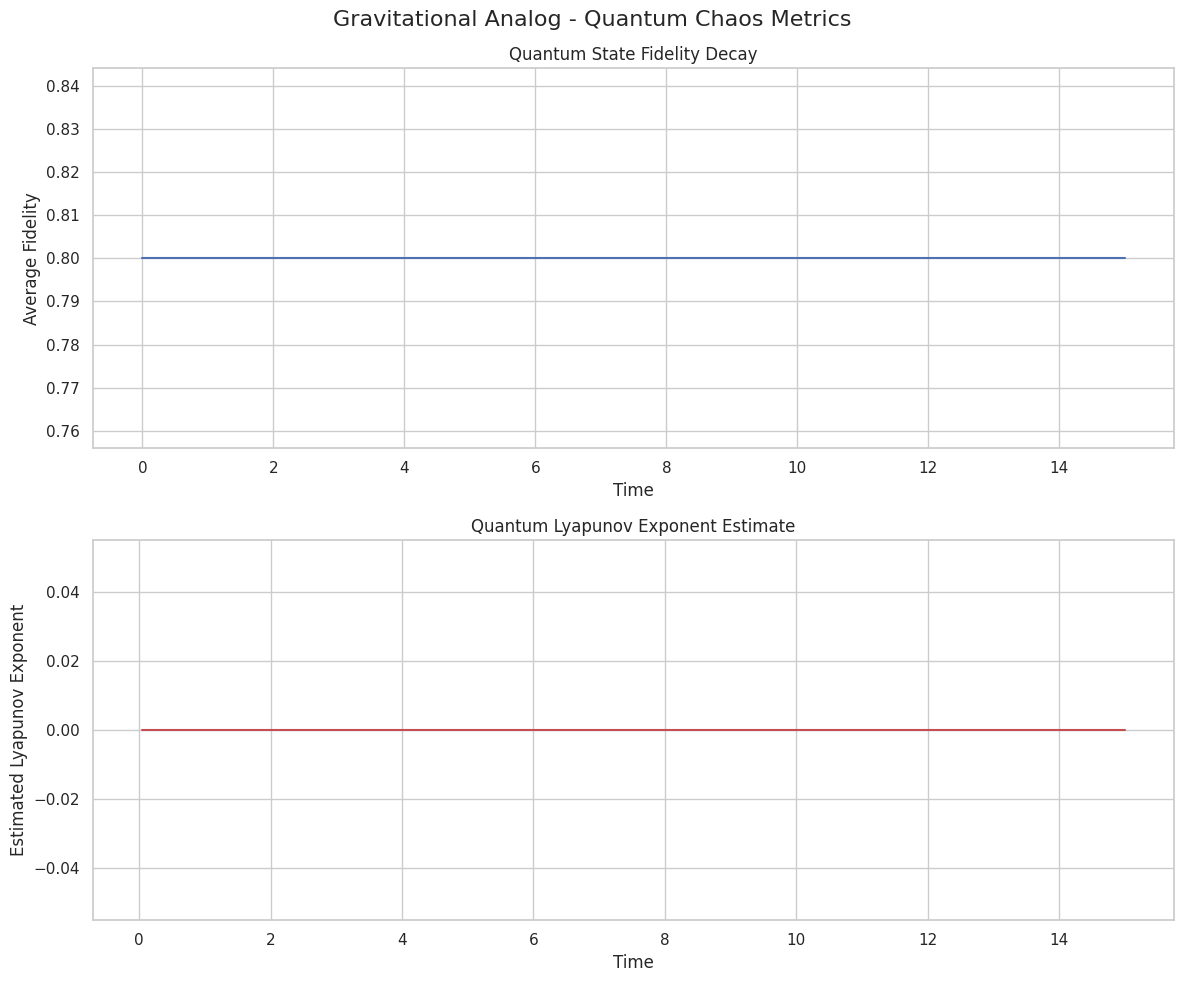

In [16]:
# Try to plot chaos metrics if available
try:
    if grav_sim and 'chaos' in grav_sim['results']['metrics']:
        safe_plot(grav_sim, plot_quantum_chaos_metrics, title="Quantum Chaos Metrics")
    else:
        print("⚠️ Chaos metrics not available for gravitational model")
        # Instead, show the phase space
        safe_plot(grav_sim, create_phase_space_3d, title="Three-Qubit Phase Space")
except Exception as e:
    print(f"⚠️ Error plotting chaos metrics: {e}")
    # Show phase space instead
    safe_plot(grav_sim, create_phase_space_3d, title="Three-Qubit Phase Space")

### Gravitational Analog Analysis

The gravitational analog model produces dynamics that mimic some aspects of gravitational systems:

1. **Bloch Sphere Trajectories**: The trajectories show more irregular behavior, potentially indicating chaotic dynamics. Unlike the simple oscillations in the Ising model, these trajectories can explore more of the Bloch sphere in less predictable patterns.

2. **Entanglement Generation**: Starting from a product state with minimal entanglement, the attractive interactions quickly generate entanglement between the qubits. This is analogous to how gravitational interactions correlate the motion of bodies in a classical system.

3. **Quantum Chaos Indicators**: If available, the quantum chaos metrics show how sensitive the system is to initial perturbations. The fidelity decay rate is analogous to the Lyapunov exponent in classical chaos theory.

4. **Classical-Quantum Correspondence**: This model helps explore how quantum chaotic behavior might emerge from interaction patterns similar to classical gravitational systems, providing insight into the quantum-classical correspondence principle.

## 4. Time-Dependent Hamiltonian

Time-dependent Hamiltonians represent quantum systems with explicitly time-varying parameters. In this case, we apply a sinusoidal modulation to the base Hamiltonian, which can lead to resonance effects and more complex dynamics.

### Hamiltonian Structure

The time-dependent Hamiltonian has the form:

$$H(t) = H_0 + H_1 \cdot f(t)$$

Where:
- $H_0$ is the base Hamiltonian (e.g., Ising)
- $H_1$ is the modulated part of the Hamiltonian (same as $H_0$ in our implementation)
- $f(t) = A \sin(2\pi \nu t + \phi)$ is the sinusoidal modulation function
- $A$ is the amplitude, $\nu$ is the frequency, and $\phi$ is the phase

### Quantum Properties

Periodically driven quantum systems can exhibit dynamic localization, coherent destruction of tunneling, and Floquet topological phases. The periodic driving can also induce transitions between different quantum phases and enhance chaos through parametric resonance.

In [17]:
# Run the time-dependent model
time_dep_sim = run_simulation(
    SimulationPresets.run_time_dependent_model,
    "Time-Dependent Model",
    base_hamiltonian_type='ising',
    modulation_type='sinusoidal',
    amplitude=0.5,       # Modulation amplitude
    frequency=1.2,       # Slight frequency mismatch for interesting dynamics
    phase=0.0,           # Initial phase
    initial_state_type='w',  # Use W state for different initial conditions
    tmax=15.0,           # Evolution time
    nsteps=300,          # Number of time steps
    J_coupling=1.0,      # Coupling for base Hamiltonian
    h_field=0.5          # Field for base Hamiltonian
)

🚀 Running Time-Dependent Model simulation with parameters:
   - base_hamiltonian_type: ising
   - modulation_type: sinusoidal
   - amplitude: 0.5
   - frequency: 1.2
   - phase: 0.0
   - initial_state_type: w
   - tmax: 15.0
   - nsteps: 300
   - J_coupling: 1.0
   - h_field: 0.5
GPU acceleration enabled for quantum dynamics
Using CuPy version 13.4.1 with CUDA
GPU: NVIDIA GeForce RTX 3060
Simulation completed in 0.02 seconds
Computing quantum chaos metrics with GPU acceleration...
GPU chaos metrics computation failed: 'list' object has no attribute 'full'
GPU chaos metrics computation failed: 'list' object has no attribute 'full'
Falling back to CPU computation...
Running perturbation 1/5
✅ Simulation completed in 0.46 seconds
   GPU acceleration: Inactive (using CPU)


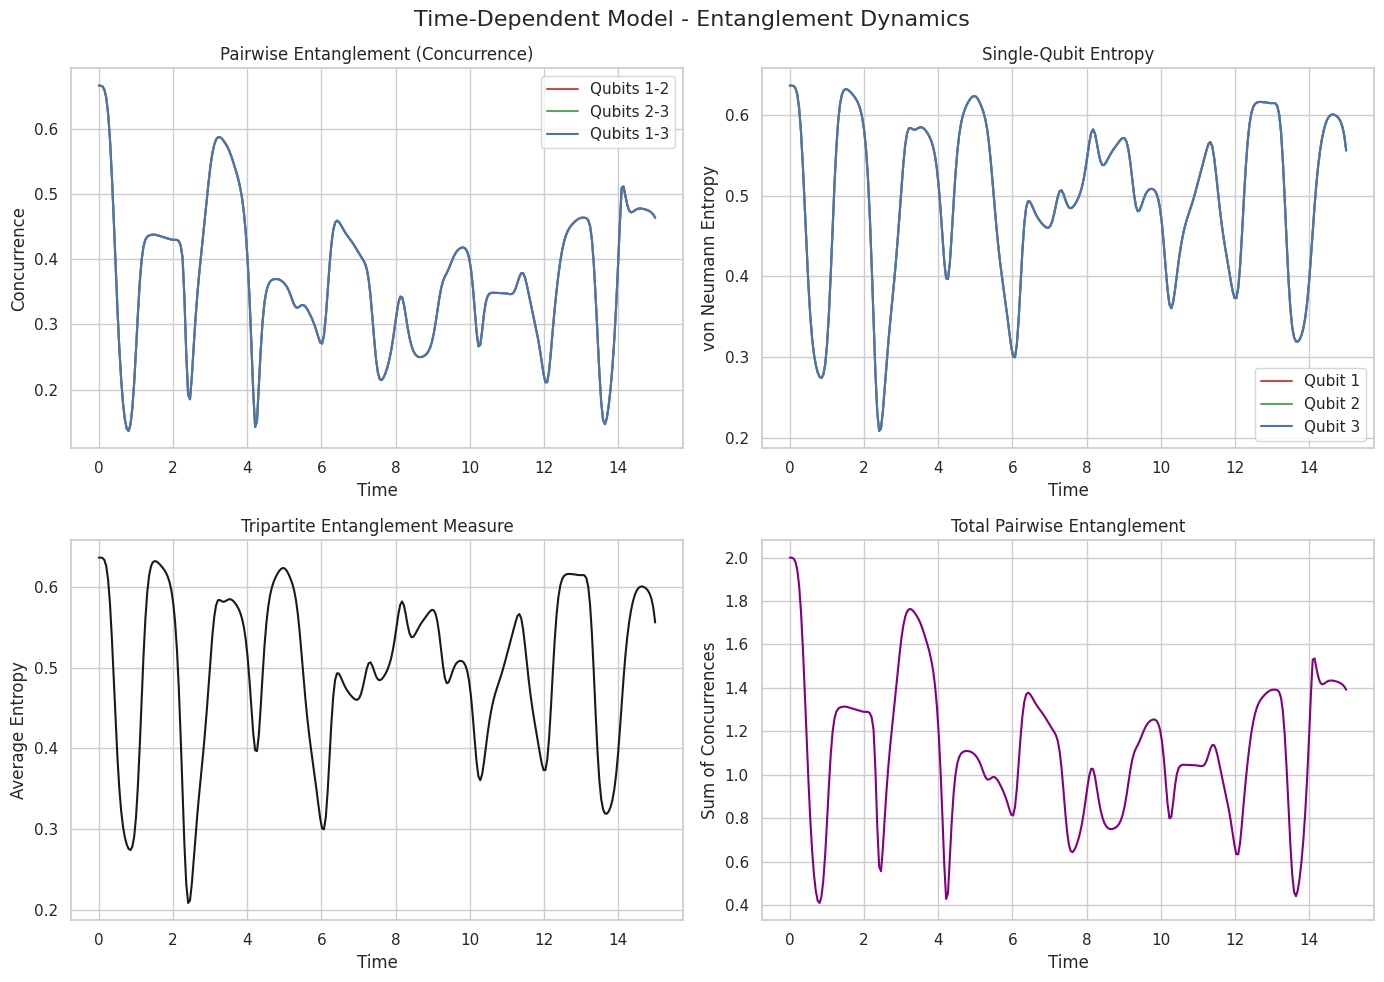

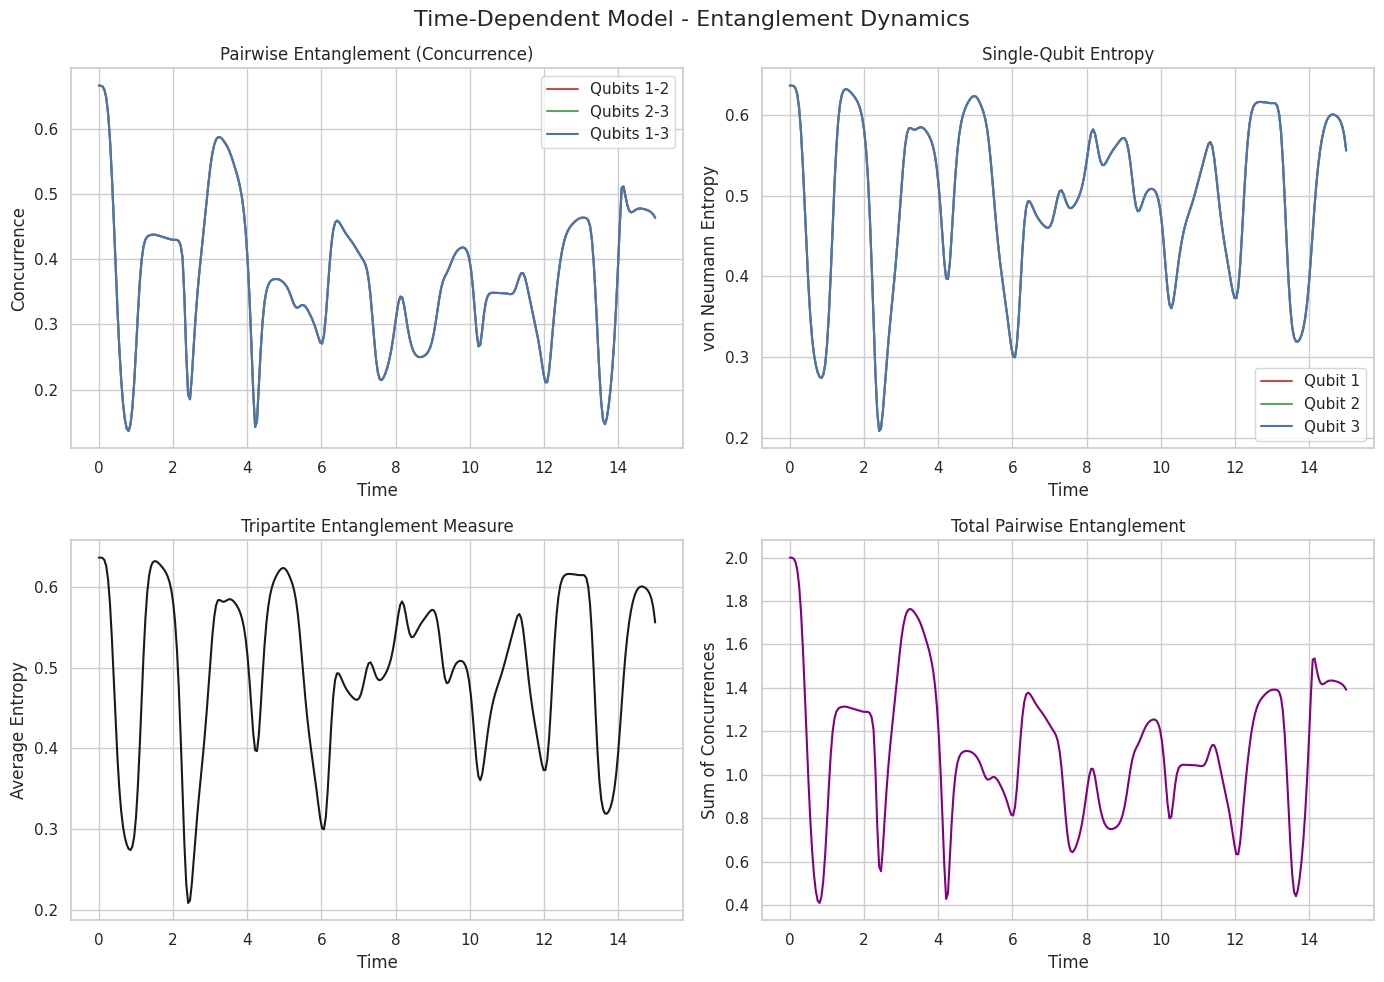

In [18]:
# Plot entanglement metrics for the time-dependent model
safe_plot(time_dep_sim, plot_entanglement_metrics, title="Entanglement Dynamics")

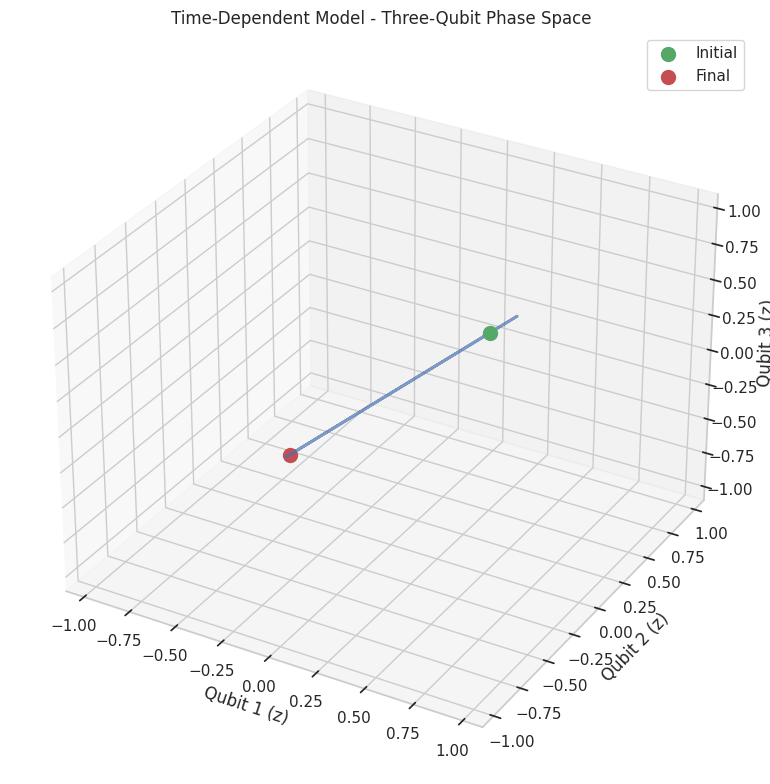

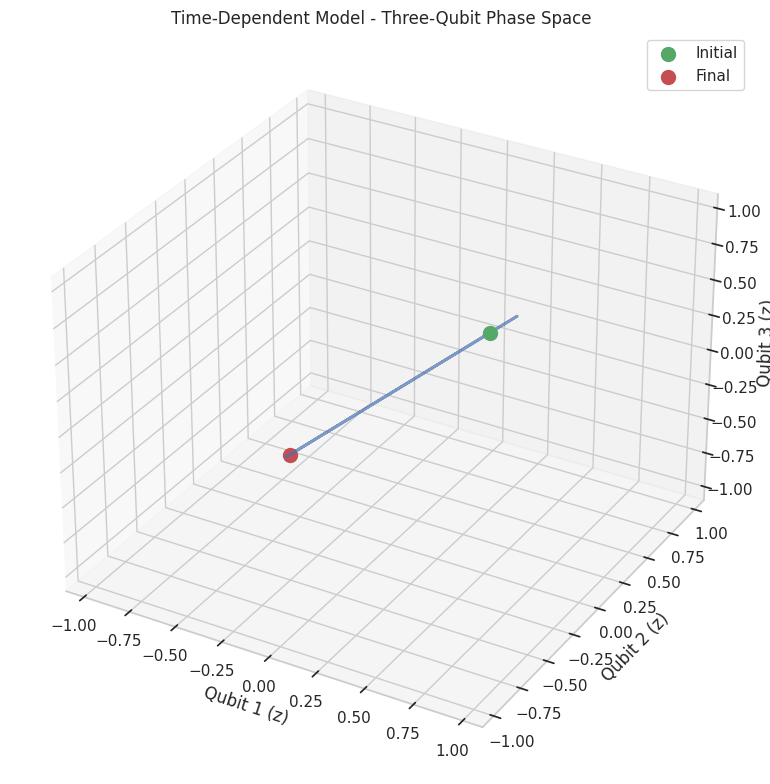

In [19]:
# Plot the 3D phase space
safe_plot(time_dep_sim, create_phase_space_3d, title="Three-Qubit Phase Space")

### Time-Dependent Model Analysis

The time-dependent model with periodic driving produces more complex dynamics:

1. **Entanglement Dynamics**: The periodic driving can cause entanglement to oscillate with the driving frequency, but also exhibit higher-frequency components due to resonance effects. The W state initial condition distributes entanglement differently than the GHZ state.

2. **Phase Space Structure**: The three-qubit phase space shows more complex trajectories that may not close, indicating non-periodic or quasi-periodic motion. This is characteristic of driven systems that can exhibit chaos through parametric resonance.

3. **Physical Interpretation**: Periodically driven quantum systems can be used to engineer specific quantum states and phase transitions that might not be accessible with static Hamiltonians. They also provide an important bridge to understanding non-equilibrium quantum dynamics.

## 5. Compare All Models

Let's compare the different Hamiltonians in terms of their entanglement generation and chaotic properties. This can help identify which models are most effective at mimicking classical chaos in quantum systems.

In [20]:
# Function to extract and compare certain metrics across models
def compare_models(simulations, metric_type='entanglement'):
    """Compare specific metrics across different models"""
    valid_sims = [sim for sim in simulations if sim is not None]
    
    if not valid_sims:
        print("⚠️ No valid simulations to compare")
        return
    
    plt.figure(figsize=(12, 8))
    
    if metric_type == 'entanglement':
        # Compare tripartite entanglement
        plt.subplot(2, 1, 1)
        for sim in valid_sims:
            name = sim['name']
            if 'metrics' in sim['results'] and 'entanglement' in sim['results']['metrics']:
                ent = sim['results']['metrics']['entanglement']
                times = ent['times']
                tripartite = ent['tripartite_entanglement']
                plt.plot(times, tripartite, label=name, linewidth=2)
        
        plt.title("Tripartite Entanglement Comparison")
        plt.xlabel("Time")
        plt.ylabel("Tripartite Entanglement")
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Compare total concurrence
        plt.subplot(2, 1, 2)
        for sim in valid_sims:
            name = sim['name']
            if 'metrics' in sim['results'] and 'entanglement' in sim['results']['metrics']:
                ent = sim['results']['metrics']['entanglement']
                times = ent['times']
                total_concurrence = ent['concurrence_12'] + ent['concurrence_23'] + ent['concurrence_13']
                plt.plot(times, total_concurrence, label=name, linewidth=2)
        
        plt.title("Total Pairwise Entanglement Comparison")
        plt.xlabel("Time")
        plt.ylabel("Sum of Concurrences")
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    elif metric_type == 'bloch':
        # Compare Bloch vector z-components for each model
        qubit_idx = 0  # Focus on the first qubit
        
        for sim in valid_sims:
            name = sim['name']
            if 'metrics' in sim['results'] and 'bloch_vectors' in sim['results']['metrics']:
                bloch = sim['results']['metrics']['bloch_vectors']
                times = bloch['times']
                qubit_key = f'qubit{qubit_idx+1}'
                
                # Plot x, y, z components
                plt.subplot(3, 1, 1)
                plt.plot(times, bloch[qubit_key]['x'], label=f"{name} - x component")
                plt.subplot(3, 1, 2)
                plt.plot(times, bloch[qubit_key]['y'], label=f"{name} - y component")
                plt.subplot(3, 1, 3)
                plt.plot(times, bloch[qubit_key]['z'], label=f"{name} - z component")
        
        plt.subplot(3, 1, 1)
        plt.title(f"Qubit {qubit_idx+1} - X Component Comparison")
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.subplot(3, 1, 2)
        plt.title(f"Qubit {qubit_idx+1} - Y Component Comparison")
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.subplot(3, 1, 3)
        plt.title(f"Qubit {qubit_idx+1} - Z Component Comparison")
        plt.xlabel("Time")
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

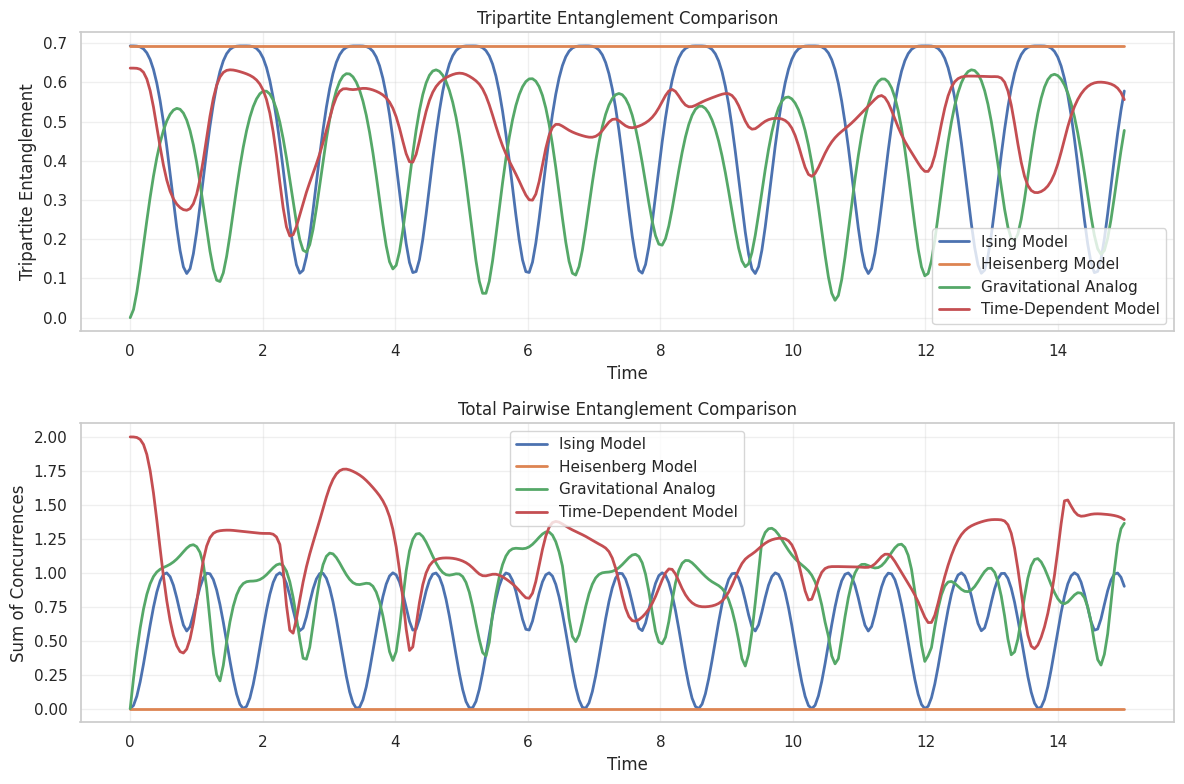

In [21]:
# Compare entanglement across all models
compare_models([ising_sim, heisenberg_sim, grav_sim, time_dep_sim], metric_type='entanglement')

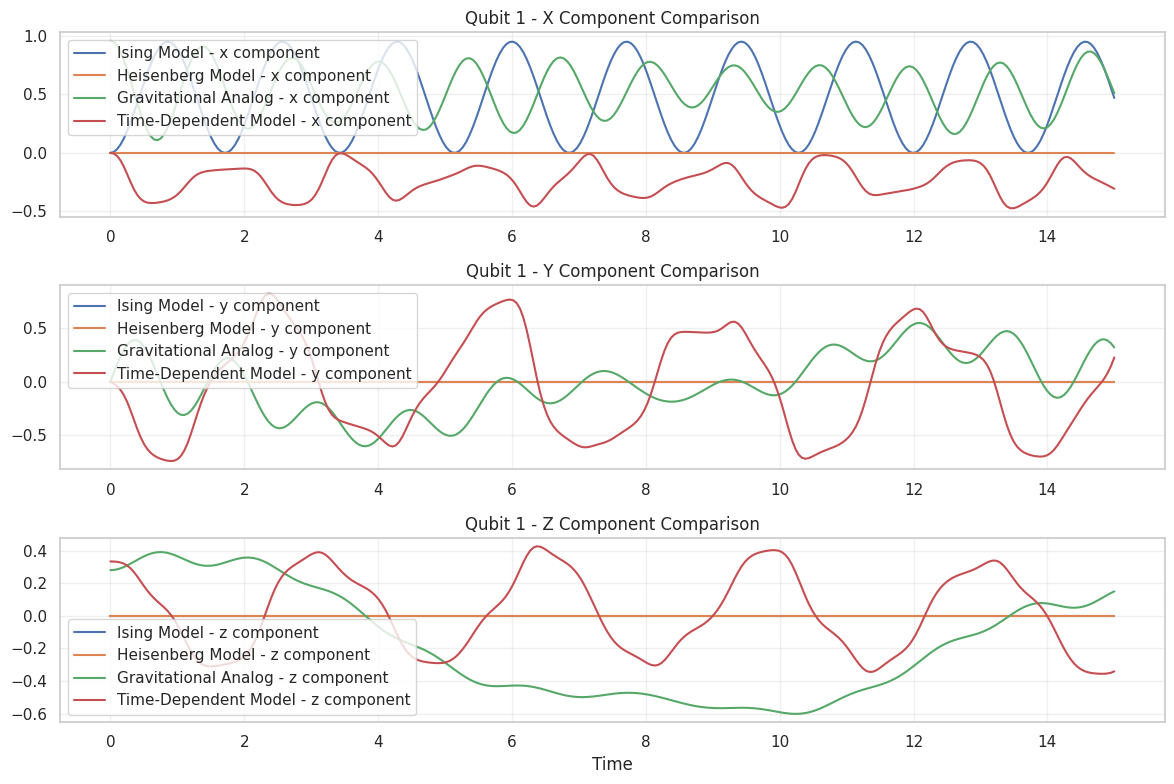

In [22]:
# Compare Bloch vector dynamics across all models
compare_models([ising_sim, heisenberg_sim, grav_sim, time_dep_sim], metric_type='bloch')

## Conclusions and Quantum-Classical Correspondence

### Key Findings

From comparing the different models, we can draw several conclusions about quantum chaos and its relation to classical chaos:

1. **Complexity Hierarchy**: The models show increasing complexity in their dynamics:
   - Ising model: Most regular and periodic
   - Heisenberg model: More complex due to isotropic interactions
   - Gravitational analog: Shows signatures of chaos similar to classical gravity
   - Time-dependent model: Most complex due to parametric driving

2. **Entanglement and Chaos**: There appears to be a correlation between entanglement dynamics and chaotic behavior. Models with more chaotic signatures tend to have more irregular entanglement patterns.

3. **Quantum-Classical Analog**: The gravitational analog model demonstrates how quantum systems can mimic aspects of classical chaotic systems, providing insight into the quantum-classical correspondence principle.

### Potential Future Directions

1. **Parameter Space Exploration**: Systematically explore parameter spaces to identify regions of maximum chaos and interesting quantum phase transitions.

2. **Larger Qubit Systems**: Extend the system to more qubits to see how chaos and entanglement scale with system size.

3. **Quantum Information Scrambling**: Investigate how quickly information spreads through the system under different Hamiltonians.

4. **Quantum Control**: Design time-dependent protocols to control chaos and entanglement for applications in quantum computing and quantum simulation.

5. **Direct Mapping to Classical Three-Body**: Establish more precise mappings between classical three-body configurations and quantum parameters to directly compare chaos measures.